In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback

data = pd.read_csv(r"../../Day2/data/train_new.csv").drop(columns=['id'])

## 特征与Label关系分析

### 关联性

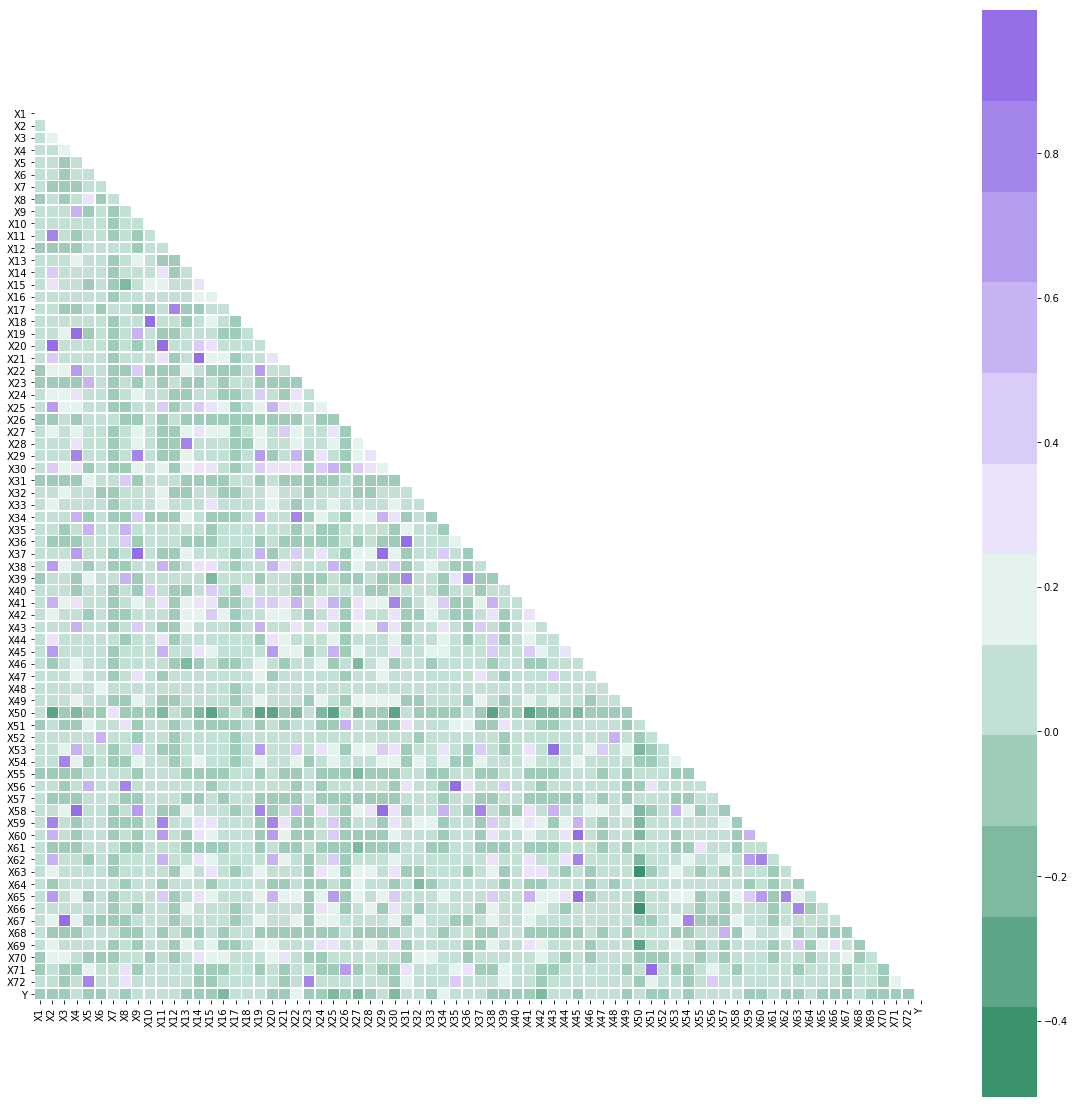

In [2]:
corr_map = data.corr()
plt.figure(figsize=(20, 20))
mask = np.triu(np.ones_like(corr_map, dtype=np.bool))
cmap = sns.diverging_palette(150, 275, s=80, l=55, n=12)
sns.heatmap(corr_map, mask=mask, cmap=cmap, square=True, linewidths=.5)
plt.savefig('../assets/corr.svg', format='svg')

In [3]:
data.corr()['Y'].where(abs(data.corr()['Y']) > 0.12).drop(labels=['Y']).dropna()

X14   -0.128984
X16   -0.140307
X22    0.145208
X25   -0.146208
X27   -0.244145
X30   -0.164431
X34    0.141244
X42   -0.151542
Name: Y, dtype: float64

### WOE与IV指标

In [4]:
max_bin = 20
force_bin = 3

# define a binning function
def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

In [5]:
final_iv, IV = data_vars(data, data.Y)
IV = IV.set_index('VAR_NAME').loc[[('X' + str(i)) for i in range(1, 73)]].reset_index()

In [6]:
final_iv.head(10)

,VAR_NAME,MIN_VALUE,MAX_VALUE,COUNT,EVENT,EVENT_RATE,NONEVENT,NON_EVENT_RATE,DIST_EVENT,DIST_NON_EVENT,WOE,IV
0,X1,0.0,4.0,17694,6606.0,0.373347,11088.0,0.626653,0.347282,0.357931,-0.030204,0.020252
1,X1,5.0,7.0,12115,4422.0,0.365002,7693.0,0.634998,0.232468,0.248338,-0.066038,0.020252
2,X1,8.0,11.0,14340,5225.0,0.364365,9115.0,0.635635,0.274682,0.294241,-0.068786,0.020252
3,X1,NaN,NaN,5851,2769.0,0.473252,3082.0,0.526748,0.145568,0.099490,0.380589,0.020252
4,X2,0.0,537.0,12439,5333.0,0.428732,7106.0,0.571268,0.280360,0.229389,0.200656,0.020812
5,X2,538.0,873.0,12402,4670.0,0.376552,7732.0,0.623448,0.245505,0.249596,-0.016527,0.020812
6,X2,874.0,1358.0,12376,4533.0,0.366273,7843.0,0.633727,0.238303,0.253180,-0.060556,0.020812
7,X2,1359.0,15350.0,12393,4272.0,0.344711,8121.0,0.655289,0.224582,0.262154,-0.154690,0.020812
8,X2,NaN,NaN,390,214.0,0.548718,176.0,0.451282,0.011250,0.005681,0.683173,0.020812
9,X3,0.0,227.0,24606,9096.0,0.369666,15510.0,0.630334,0.478183,0.500678,-0.045969,0.006088


<Figure size 2160x1080 with 0 Axes>

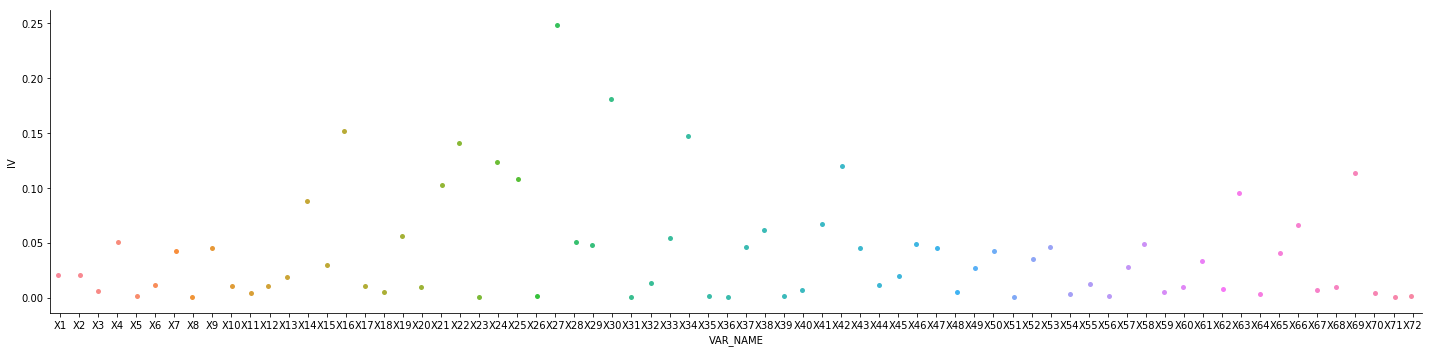

In [7]:
plt.figure(figsize=(30,15))
sns.catplot(x='VAR_NAME', y='IV', data=IV, aspect=4)

In [8]:
IV.where(IV > 0.1).dropna().sort_values(by='IV', ascending=False)

,VAR_NAME,IV
26,X27,0.248032
29,X30,0.180453
15,X16,0.151433
33,X34,0.147362
21,X22,0.140866
23,X24,0.123124
41,X42,0.119806
68,X69,0.113160
24,X25,0.107627
20,X21,0.102219


## 特征工程

### Normalization

In [9]:
digital_cols = data.dtypes[data.dtypes != 'object'].index
nor_data = data.copy()
nor_data[digital_cols] = nor_data[digital_cols].apply(lambda x: (x - x.mean()) / (x.std()))
nor_data.head(10)

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X64,X65,X66,X67,X68,X69,X70,X71,X72,Y
0,1.029154,0.538781,5.607751,-0.070962,-0.020829,-0.103187,-0.095701,NaN,-0.798870,-0.253708,...,-0.017108,-0.910740,0.440512,4.743993,0.234886,-0.210486,0.349606,-0.070304,-0.017537,1.276128
1,-1.044798,-1.042146,-0.473350,-0.569373,NaN,0.062788,-0.095701,NaN,-0.404132,0.016640,...,-1.133859,-0.726820,1.218165,-0.475500,0.741694,-0.281526,-0.833314,NaN,NaN,1.276128
2,-1.044798,0.010060,-0.423590,-1.192385,-0.020829,-0.099579,-0.095701,NaN,-0.404132,0.142251,...,1.188724,0.798183,0.986677,-0.428477,-0.027256,-0.587309,0.349606,-0.070304,-0.017537,-0.783605
3,1.325433,0.460258,-0.245518,-0.444770,-0.020829,0.062788,-0.095701,NaN,-0.404132,0.148839,...,1.128315,-0.880087,-1.530746,-0.248937,0.042648,-0.568004,0.349606,-0.070304,-0.017537,1.276128
4,-1.044798,0.063717,-0.378450,0.053640,-0.020829,0.062788,-0.095701,NaN,-0.009394,0.091743,...,0.986039,-0.251693,-0.232248,-0.383592,-0.551540,-0.215891,-0.833314,-0.070304,-0.017537,-0.783605
5,0.140318,-0.453225,-0.463398,-0.693975,-0.020829,-0.117259,-0.095701,NaN,-0.009394,-0.187477,...,0.019318,-0.657850,1.196463,-0.466950,0.497028,-0.277666,0.349606,-0.070304,-0.017537,-0.783605
6,0.732876,-0.215039,0.429449,1.175063,-0.020829,0.062788,-0.095701,NaN,-0.798870,-0.202630,...,-0.069041,-0.504583,-0.196078,0.426477,-0.586493,-0.078444,0.349606,-0.070304,-0.017537,-0.783605
7,0.140318,-0.281783,2.455772,-0.569373,-0.020829,-0.117440,-0.095701,NaN,0.385345,0.322784,...,0.290286,-0.167397,0.360938,2.456992,-0.464160,0.496057,0.349606,-0.070304,-0.017537,-0.783605
8,-1.637355,0.889516,1.552262,1.299665,-0.020829,-0.117259,-0.095701,NaN,-0.404132,0.144228,...,0.024006,-0.611870,1.380929,1.552878,0.060124,0.021167,0.349606,-0.070304,-0.017537,1.276128
9,0.436597,0.894751,1.758768,1.175063,-0.020829,-0.063498,-0.095701,NaN,2.753775,-0.046385,...,-0.027386,-0.358980,-0.470969,1.760204,-0.796206,1.140825,0.349606,-0.070304,-0.017537,-0.783605


In [10]:
num_train = int(nor_data.shape[0] * 0.8)
train_data = nor_data[:num_train]
test_data = nor_data[num_train:]
train_data.to_csv('../data/train_nor.csv', sep=',', index=False, header=True)
train_data.to_csv('../data/test_nor.csv', sep=',', index=False, header=True)

### WOE

In [11]:
data.columns.difference(['target'])

Index(['X1', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18',
       'X19', 'X2', 'X20', 'X21', 'X22', 'X23', 'X24', 'X25', 'X26', 'X27',
       'X28', 'X29', 'X3', 'X30', 'X31', 'X32', 'X33', 'X34', 'X35', 'X36',
       'X37', 'X38', 'X39', 'X4', 'X40', 'X41', 'X42', 'X43', 'X44', 'X45',
       'X46', 'X47', 'X48', 'X49', 'X5', 'X50', 'X51', 'X52', 'X53', 'X54',
       'X55', 'X56', 'X57', 'X58', 'X59', 'X6', 'X60', 'X61', 'X62', 'X63',
       'X64', 'X65', 'X66', 'X67', 'X68', 'X69', 'X7', 'X70', 'X71', 'X72',
       'X8', 'X9', 'Y'],
      dtype='object')

In [12]:
woe_data = data.copy()
woe_data.fillna(-1,inplace=True)
transform_vars_list = woe_data.columns.difference(['target'])
transform_prefix = 'new_'

for var in transform_vars_list:
    small_df = final_iv[final_iv['VAR_NAME'] == var]
    transform_dict = dict(zip(small_df.MAX_VALUE,small_df.WOE))
    replace_cmd = ''
    replace_cmd1 = ''
    for i in sorted(transform_dict.items()):
        replace_cmd = replace_cmd + str(i[1]) + str(' if x <= ') + str(i[0]) + ' else '
        replace_cmd1 = replace_cmd1 + str(i[1]) + str(' if x == "') + str(i[0]) + '" else '
    replace_cmd = replace_cmd + '0'
    replace_cmd1 = replace_cmd1 + '0'
    if replace_cmd != '0':
        try:
            woe_data[transform_prefix + var] = woe_data[var].apply(lambda x: eval(replace_cmd))
        except:
            woe_data[transform_prefix + var] = woe_data[var].apply(lambda x: eval(replace_cmd1))

In [13]:
woe_data.head(10)

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,new_X66,new_X67,new_X68,new_X69,new_X7,new_X70,new_X71,new_X72,new_X8,new_X9
0,9.0,1458.0,17147.0,10.0,0.0,800.0,0.0,-1.0,0.0,679.0,...,-0.132239,0.032072,0.067623,-0.067478,-0.069283,-0.006444,-0.012368,-0.021207,0.028149,-0.077070
1,2.0,250.0,38.0,6.0,-1.0,10000.0,0.0,-1.0,1.0,12990.0,...,-0.215921,-0.050200,0.067623,-0.067478,-0.069283,-0.006444,-0.012368,-0.021207,0.028149,-0.077070
2,2.0,1054.0,178.0,1.0,0.0,1000.0,0.0,-1.0,1.0,18710.0,...,-0.215921,-0.050200,0.024377,0.162574,-0.069283,-0.006444,-0.012368,-0.021207,0.028149,-0.077070
3,10.0,1398.0,679.0,7.0,0.0,10000.0,0.0,-1.0,1.0,19010.0,...,0.137670,0.032072,0.024377,0.162574,-0.069283,-0.006444,-0.012368,-0.021207,0.028149,-0.077070
4,2.0,1095.0,305.0,11.0,0.0,10000.0,0.0,-1.0,2.0,16410.0,...,-0.132239,0.032072,-0.111148,-0.067478,-0.069283,-0.006444,-0.012368,-0.021207,0.028149,-0.054235
5,6.0,700.0,66.0,5.0,0.0,20.0,0.0,-1.0,2.0,3695.0,...,-0.215921,-0.050200,0.067623,-0.067478,-0.069283,-0.006444,-0.012368,-0.021207,0.028149,-0.054235
6,8.0,882.0,2578.0,20.0,0.0,10000.0,0.0,-1.0,0.0,3005.0,...,-0.132239,0.032072,-0.111148,-0.067478,-0.069283,-0.006444,-0.012368,-0.021207,0.028149,-0.077070
7,6.0,831.0,8279.0,6.0,0.0,10.0,0.0,-1.0,3.0,26931.0,...,-0.132239,0.032072,-0.111148,-0.555471,-0.069283,-0.006444,-0.012368,-0.021207,0.028149,-0.054235
8,0.0,1726.0,5737.0,21.0,0.0,20.0,0.0,-1.0,1.0,18800.0,...,-0.215921,0.032072,0.024377,-0.067478,-0.069283,-0.006444,-0.012368,-0.021207,0.028149,-0.077070
9,7.0,1730.0,6318.0,20.0,0.0,3000.0,0.0,-1.0,9.0,10120.0,...,-0.132239,0.032072,-0.111148,-0.555471,-0.069283,-0.006444,-0.012368,-0.021207,0.028149,-0.054235


In [14]:
num_train = int(woe_data.shape[0] * 0.8)
train_data = woe_data[:num_train]
test_data = woe_data[num_train:]
train_data.to_csv('../data/train_woe.csv', sep=',', index=False, header=True)
train_data.to_csv('../data/test_woe.csv', sep=',', index=False, header=True)

### 特征交叉

In [15]:
def add_cross_feature(data, feature_1, feature_2):
    comb_index = data[[feature_1, feature_2]].drop_duplicates()
    comb_index[feature_1 + '_' + feature_2] = np.arange(comb_index.shape[0])
    data = pd.merge(data, comb_index, 'left', on=[feature_1, feature_2])
    return data

In [16]:
cross_data = data.copy()
cross_data.X27 = pd.qcut(cross_data.X27, q=10, duplicates='drop')
cross_data.X30 = pd.qcut(cross_data.X30, q=10, duplicates='drop')
cross_data = add_cross_feature(cross_data, 'X27', 'X30')

In [17]:
cross_data.head(10)

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X65,X66,X67,X68,X69,X70,X71,X72,Y,X27_X30
0,9.0,1458.0,17147.0,10.0,0.0,800.0,0.0,NaN,0.0,679.0,...,7.0,581.0,2449.0,93.0,498.0,6.0,0.0,0.0,1,0
1,2.0,250.0,38.0,6.0,NaN,10000.0,0.0,NaN,1.0,12990.0,...,31.0,796.0,7.0,122.0,406.0,5.0,NaN,NaN,1,1
2,2.0,1054.0,178.0,1.0,0.0,1000.0,0.0,NaN,1.0,18710.0,...,230.0,732.0,29.0,78.0,10.0,6.0,0.0,0.0,0,2
3,10.0,1398.0,679.0,7.0,0.0,10000.0,0.0,NaN,1.0,19010.0,...,11.0,36.0,113.0,82.0,35.0,6.0,0.0,0.0,1,3
4,2.0,1095.0,305.0,11.0,0.0,10000.0,0.0,NaN,2.0,16410.0,...,93.0,395.0,50.0,48.0,491.0,5.0,0.0,0.0,0,4
5,6.0,700.0,66.0,5.0,0.0,20.0,0.0,NaN,2.0,3695.0,...,40.0,790.0,11.0,108.0,411.0,6.0,0.0,0.0,0,5
6,8.0,882.0,2578.0,20.0,0.0,10000.0,0.0,NaN,0.0,3005.0,...,60.0,405.0,429.0,46.0,669.0,6.0,0.0,0.0,0,6
7,6.0,831.0,8279.0,6.0,0.0,10.0,0.0,NaN,3.0,26931.0,...,104.0,559.0,1379.0,53.0,1413.0,6.0,0.0,0.0,0,7
8,0.0,1726.0,5737.0,21.0,0.0,20.0,0.0,NaN,1.0,18800.0,...,46.0,841.0,956.0,83.0,798.0,6.0,0.0,0.0,1,8
9,7.0,1730.0,6318.0,20.0,0.0,3000.0,0.0,NaN,9.0,10120.0,...,79.0,329.0,1053.0,34.0,2248.0,6.0,0.0,0.0,0,9


In [18]:
num_train = int(cross_data.shape[0] * 0.8)
train_data = cross_data[:num_train]
test_data = cross_data[num_train:]
train_data.to_csv('../data/train_cross.csv', sep=',', index=False, header=True)
train_data.to_csv('../data/test_cross.csv', sep=',', index=False, header=True)